In [ ]:
import pandas as pd

# Define file path
file_path = "/content/drive/MyDrive/Salinas_Reduced.csv"

# Load dataset
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22213 entries, 0 to 22212
Columns: 205 entries, band-1 to class
dtypes: int64(205)
memory usage: 34.7 MB


(None,
    band-1  band-2  band-3  band-4  band-5  band-6  band-7  band-8  band-9  \
 0     378     477     731    1303    1520    1580    1489    1674    1892   
 1     377     485     661    1170    1506    1557    1515    1695    1923   
 2     364     474     592    1039    1408    1463    1432    1594    1849   
 3     453     394     732    1175    1500    1578    1528    1711    1981   
 4     442     563     737    1217    1582    1695    1643    1825    2110   
 
    band-10  ...  band-196  band-197  band-198  band-199  band-200  band-201  \
 0     1941  ...       170       194       164       101       152       100   
 1     1996  ...       175       213       177       109       164       110   
 2     1926  ...       101       121        94        62        82        62   
 3     2035  ...       186       224       189       121       176       116   
 4     2186  ...       169       211       181       113       163       114   
 
    band-202  band-203  band-204  class  

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
file_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df = pd.read_csv(file_path)

# Extract Features and Labels
X = df.iloc[:, :-1].values  # First 204 columns as features
y = df.iloc[:, -1].values   # Last column as labels

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Tensors
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)

# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []

    for episode in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        print(f"Episode {episode + 1}: Selected Classes -> {selected_classes}")  # Print selected classes

        support_set, query_set = [], []
        support_labels, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            if len(indices) < (k_shot + query_per_class):
                continue  # Skip this class if not enough samples

            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)

            support_set.append(X[selected_indices[:k_shot]])
            query_set.append(X[selected_indices[k_shot:]])

            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)

        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))

    return dataset

# Define Few-Shot Dataset Parameters
n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500

# Create Few-Shot Training Data
few_shot_data = create_few_shot_batches(X, y, n_way, k_shot, query_per_class, episodes)

# Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 204, 128)  # Adjusted for 204 bands

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 204) -> (batch, 1, 204)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Ensure correct shape before computing distances
        query_embeddings = query_embeddings.view(-1, prototypes.shape[-1])

        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2
        return -dists

# Initialize Model and Optimizer
model = PrototypicalNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_few_shot_model(model, data, optimizer, criterion, epochs=100):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            support_y = torch.tensor(support_y, dtype=torch.long, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x)
            loss = criterion(outputs, query_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

        epoch_loss = total_loss / len(data)
        epoch_acc = total_correct / total_samples * 100
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Evaluation Function with Class-Wise Accuracy
def evaluate_few_shot_model(model, data):
    model.eval()
    total_correct = 0
    total_samples = 0
    class_correct = {}
    class_total = {}

    with torch.no_grad():
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            outputs = model(support_x, query_x)
            preds = outputs.argmax(dim=1)

            total_correct += (preds == query_y).sum().item()
            total_samples += query_y.size(0)

            # Class-wise calculation
            for label in torch.unique(query_y):
                label = label.item()
                class_correct[label] = class_correct.get(label, 0) + (preds[query_y == label] == label).sum().item()
                class_total[label] = class_total.get(label, 0) + (query_y == label).sum().item()

    # Print Class-Wise Accuracy
    print("\nClass-Wise Accuracy:")
    for cls in sorted(class_correct.keys()):
        acc = (class_correct[cls] / class_total[cls]) * 100 if class_total[cls] > 0 else 0
        print(f"Class {cls}: {acc:.2f}%")

    # Print Overall Accuracy
    overall_accuracy = total_correct / total_samples * 100
    print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")

# Train and Evaluate Model
if torch.cuda.is_available():
    print("Training on CUDA...")
    train_few_shot_model(model, few_shot_data, optimizer, criterion, epochs=300)
    evaluate_few_shot_model(model, few_shot_data)
else:
    print("Training on CPU (slower).")
    train_few_shot_model(model, few_shot_data, optimizer, criterion, epochs=150)
    evaluate_few_shot_model(model, few_shot_data)

Using device: cuda
Episode 1: Selected Classes -> [ 8 11 13  0 16]
Episode 2: Selected Classes -> [12  8  7 15 13]
Episode 3: Selected Classes -> [ 6 15  8 16 10]
Episode 4: Selected Classes -> [15  4 13  3  8]
Episode 5: Selected Classes -> [12  5  4 13 10]
Episode 6: Selected Classes -> [15 10  3 11 16]
Episode 7: Selected Classes -> [ 2 15 16  7  9]
Episode 8: Selected Classes -> [ 8  5 10 16 15]
Episode 9: Selected Classes -> [11 12  2  6  5]
Episode 10: Selected Classes -> [10  7  5 14 16]
Episode 11: Selected Classes -> [ 3 10  6 11 12]
Episode 12: Selected Classes -> [ 8  5  3 10  9]
Episode 13: Selected Classes -> [12  0 10  1 15]
Episode 14: Selected Classes -> [ 5  1  4  7 16]
Episode 15: Selected Classes -> [12  4 14  0  8]
Episode 16: Selected Classes -> [ 8 10 11  2  0]
Episode 17: Selected Classes -> [14  3  9  4  6]
Episode 18: Selected Classes -> [10  1 13 12  9]
Episode 19: Selected Classes -> [11  5 16 10 13]
Episode 20: Selected Classes -> [ 2  0  1  6 10]
Episode 21

In [ ]:
import os
import torch

# Define model directory and path
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_save_path = os.path.join(model_dir, "PrototypicalNetwork_Salinas.pth")

# Create directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/Model_Checkpoints/PrototypicalNetwork_Salinas.pth


In [ ]:
# Check if model exists before loading
if os.path.exists(model_save_path):
    model = PrototypicalNetwork().to(device)
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.eval()
    print(f"Model loaded successfully from: {model_save_path}")
else:
    print("Model file not found. Train and save the model first.")


Model loaded successfully from: /content/drive/MyDrive/Model_Checkpoints/PrototypicalNetwork_Salinas.pth


<ipython-input-6-ad866277e965>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

def evaluate_few_shot_model(model, data):
    model.eval()
    total_correct = 0
    total_samples = 0
    class_correct = {}
    class_total = {}

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            outputs = model(support_x, query_x)  # Get logits (negative squared distances)
            probs = F.softmax(outputs, dim=1)  # Convert to probabilities

            preds = outputs.argmax(dim=1)

            total_correct += (preds == query_y).sum().item()
            total_samples += query_y.size(0)

            all_labels.extend(query_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # Class-wise calculation
            for label in torch.unique(query_y):
                label = label.item()
                class_correct[label] = class_correct.get(label, 0) + (preds[query_y == label] == label).sum().item()
                class_total[label] = class_total.get(label, 0) + (query_y == label).sum().item()

    # Print Class-Wise Accuracy
    print("\nClass-Wise Accuracy:")
    for cls in sorted(class_correct.keys()):
        acc = (class_correct[cls] / class_total[cls]) * 100 if class_total[cls] > 0 else 0
        print(f"Class {cls}: {acc:.2f}%")

    # Print Overall Accuracy
    overall_accuracy = total_correct / total_samples * 100
    print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")

    return np.array(all_labels), np.array(all_probs)  # Return true labels and predicted probabilities



Class-Wise Accuracy:
Class 0: 99.90%
Class 1: 99.88%
Class 2: 99.96%
Class 3: 99.88%
Class 4: 99.86%

Overall Test Accuracy: 99.90%


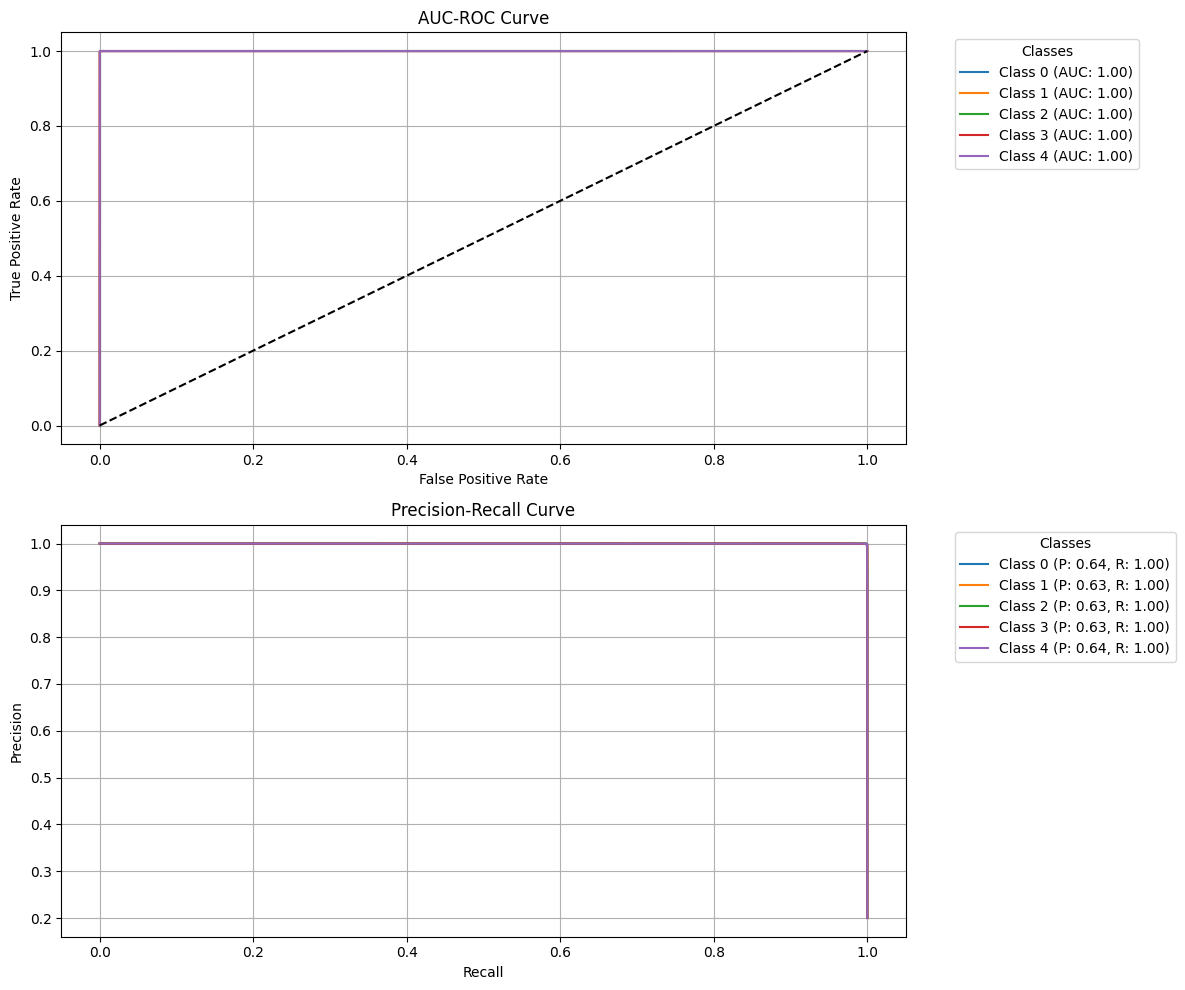


Precision-Recall Values:
Class 0: (P: 0.64, R: 1.00)
Class 1: (P: 0.63, R: 1.00)
Class 2: (P: 0.63, R: 1.00)
Class 3: (P: 0.63, R: 1.00)
Class 4: (P: 0.64, R: 1.00)


In [ ]:
def plot_auc_roc_prc(y_true, y_probs):
    n_classes = y_probs.shape[1]  # Automatically detect number of classes
    fpr, tpr, roc_auc = {}, {}, {}
    precision, recall, prc_auc = {}, {}, {}

    for i in range(n_classes):
        y_class = (y_true == i).astype(int)  # Convert to binary labels for class i
        fpr[i], tpr[i], _ = roc_curve(y_class, y_probs[:, i])
        precision[i], recall[i], _ = precision_recall_curve(y_class, y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        prc_auc[i] = auc(recall[i], precision[i])

    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # Plot ROC Curves
    for i in range(n_classes):
        ax[0].plot(fpr[i], tpr[i], label=f"Class {i} (AUC: {roc_auc[i]:.2f})")
    ax[0].plot([0, 1], [0, 1], "k--")  # Random classifier
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title("AUC-ROC Curve")
    ax[0].grid()

    # Plot Precision-Recall Curves
    pr_legend_labels = []
    for i in range(n_classes):
        ax[1].plot(recall[i], precision[i], label=f"Class {i}")
        avg_precision = np.mean(precision[i])
        avg_recall = np.mean(recall[i])
        pr_legend_labels.append(f"Class {i} (P: {avg_precision:.2f}, R: {avg_recall:.2f})")

    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].set_title("Precision-Recall Curve")
    ax[1].grid()

    ax[0].legend(loc="upper left", bbox_to_anchor=(1.05, 1), title="Classes")
    ax[1].legend(pr_legend_labels, loc="upper left", bbox_to_anchor=(1.05, 1), title="Classes")

    plt.tight_layout()
    plt.show()

    # Print Precision-Recall Values
    print("\nPrecision-Recall Values:")
    for i in range(n_classes):
        avg_precision = np.mean(precision[i])
        avg_recall = np.mean(recall[i])
        print(f"Class {i}: (P: {avg_precision:.2f}, R: {avg_recall:.2f})")

# Get Predictions
y_true, y_probs = evaluate_few_shot_model(model, few_shot_data)

# Call Function
plot_auc_roc_prc(y_true, y_probs)

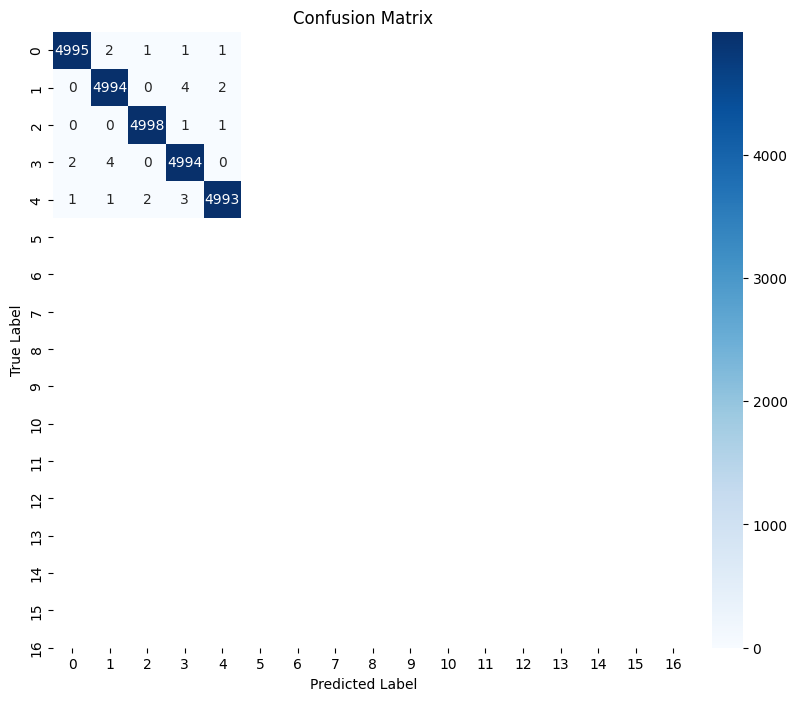

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call function after evaluation
plot_confusion_matrix(y_true, y_probs.argmax(axis=1), classes=list(range(17)))


In [ ]:
from sklearn.metrics import classification_report, f1_score

# Compute Classification Report
print(classification_report(y_true, y_probs.argmax(axis=1), digits=4))

# Print weighted F1-score
print(f"F1-Score: {f1_score(y_true, y_probs, average='weighted'):.4f}")

              precision    recall  f1-score   support

           0     0.9994    0.9990    0.9992      5000
           1     0.9986    0.9988    0.9987      5000
           2     0.9994    0.9996    0.9995      5000
           3     0.9982    0.9988    0.9985      5000
           4     0.9992    0.9986    0.9989      5000

    accuracy                         0.9990     25000
   macro avg     0.9990    0.9990    0.9990     25000
weighted avg     0.9990    0.9990    0.9990     25000



ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

Using device: cuda
Epoch 1/300 | Train Loss: 20.9871, Train Acc: 90.14% | Val Loss: 2.4754, Val Acc: 92.98%
Epoch 2/300 | Train Loss: 0.7432, Train Acc: 94.36% | Val Loss: 0.2351, Val Acc: 94.60%
Epoch 3/300 | Train Loss: 0.1080, Train Acc: 96.55% | Val Loss: 0.1418, Val Acc: 95.60%
Epoch 4/300 | Train Loss: 0.0731, Train Acc: 97.47% | Val Loss: 0.1149, Val Acc: 96.16%
Epoch 5/300 | Train Loss: 0.0591, Train Acc: 97.94% | Val Loss: 0.1123, Val Acc: 96.42%
Epoch 6/300 | Train Loss: 0.0505, Train Acc: 98.26% | Val Loss: 0.1165, Val Acc: 96.46%
Epoch 7/300 | Train Loss: 0.0424, Train Acc: 98.53% | Val Loss: 0.1214, Val Acc: 96.60%
Epoch 8/300 | Train Loss: 0.0425, Train Acc: 98.61% | Val Loss: 0.1740, Val Acc: 96.12%
Epoch 9/300 | Train Loss: 0.0703, Train Acc: 97.87% | Val Loss: 0.1360, Val Acc: 96.62%
Epoch 10/300 | Train Loss: 0.0468, Train Acc: 98.48% | Val Loss: 0.1558, Val Acc: 96.66%
Epoch 11/300 | Train Loss: 0.0387, Train Acc: 98.64% | Val Loss: 0.1714, Val Acc: 96.52%
Epoch 12/3

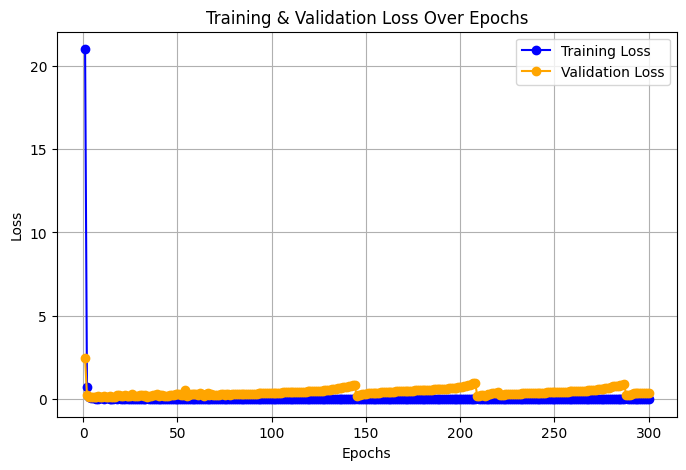

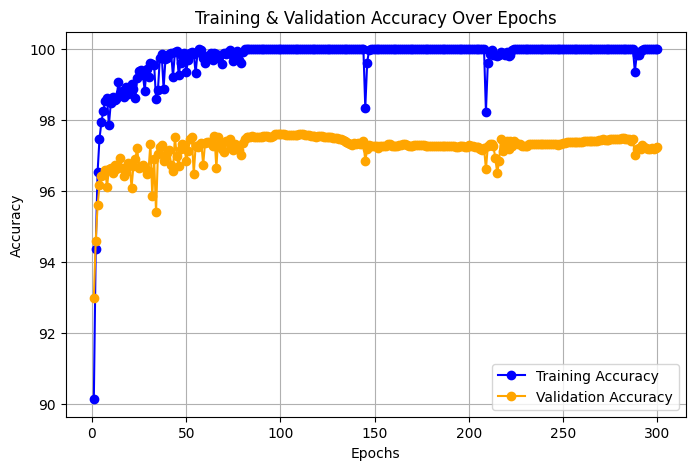

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
file_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df = pd.read_csv(file_path)

# Extract Features and Labels
X = df.iloc[:, :-1].values  # First 204 columns as features
y = df.iloc[:, -1].values   # Last column as labels

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Tensors
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)

# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []

    for episode in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        support_set, query_set = [], []
        support_labels, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            if len(indices) < (k_shot + query_per_class):
                continue  # Skip this class if not enough samples

            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)

            support_set.append(X[selected_indices[:k_shot]])
            query_set.append(X[selected_indices[k_shot:]])

            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)

        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))

    return dataset

# Define Few-Shot Dataset Parameters
n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500

# Create Few-Shot Training Data
few_shot_data = create_few_shot_batches(X, y, n_way, k_shot, query_per_class, episodes)

# Split into Training (80%) and Validation (20%)
train_data, val_data = train_test_split(few_shot_data, test_size=0.2, random_state=42)

# Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 204, 128)  # Adjusted for 204 bands

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 204) -> (batch, 1, 204)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Ensure correct shape before computing distances
        query_embeddings = query_embeddings.view(-1, prototypes.shape[-1])

        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2
        return -dists

# Initialize Model and Optimizer
model = PrototypicalNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Track loss and accuracy for plotting
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

import time  # Add this at the top of your script

start_time = time.time()  # Start tracking time

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats(device)
    initial_memory = torch.cuda.memory_allocated(device) / 1024 ** 2  # Convert to MB

# Training Function
def train_few_shot_model(model, train_data, val_data, optimizer, criterion, epochs=100):
    model.train()

    for epoch in range(epochs):
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        for support_x, support_y, query_x, query_y in train_data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            support_y = torch.tensor(support_y, dtype=torch.long, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x)
            loss = criterion(outputs, query_y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_train_samples += query_y.size(0)

        epoch_train_loss = total_train_loss / len(train_data)
        epoch_train_acc = total_train_correct / total_train_samples * 100
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation Step
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for support_x, support_y, query_x, query_y in val_data:
                support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
                query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
                query_y = torch.tensor(query_y, dtype=torch.long, device=device)

                outputs = model(support_x, query_x)
                loss = criterion(outputs, query_y)
                total_val_loss += loss.item()
                total_val_correct += (outputs.argmax(dim=1) == query_y).sum().item()
                total_val_samples += query_y.size(0)

        epoch_val_loss = total_val_loss / len(val_data)
        epoch_val_acc = total_val_correct / total_val_samples * 100
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

# Train Model
train_few_shot_model(model, train_data, val_data, optimizer, criterion, epochs=300)

end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")

if torch.cuda.is_available():
    peak_memory = torch.cuda.max_memory_allocated(device) / 1024 ** 2  # Convert to MB
    print(f"Initial GPU Memory Usage: {initial_memory:.2f} MB")
    print(f"Peak GPU Memory Usage During Training: {peak_memory:.2f} MB")

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
